# Limbers Equation Code
#### The code below will estimate the the linear bias using the angular correlation function and Limbers equation
###### Limbers Equation is used to relate the 3 dimensional Dark Matter power spectrum and the angular correlation function for objects that are separated by small angles ($\theta<<2$ deg). To make this computation, I need the following items:

* A measurement or fit of w($\theta$)
* The redshift distribution of the quasar sample ($\frac{dN}{dz}$) from the histogram (more on this below)
* The dimensionless Dark Matter Power Spectrum, $\Delta^{2}(k,z)$

The integral form of Limbers equation is:

#### $\omega(\theta) = \pi \int_{z=0}^{z=\infty} \int_{k=0}^{k=\infty} \left(\frac{\Delta^{2}(k,z)}{k}\right) J_{0}[k\theta\chi(z)] \left(\frac{dN}{dz}\right)^2 \left(\frac{dz}{d\chi}\right) F(\chi) \frac{dk}{k} dz  $

Noting that $\Delta^{2}(k,z) = b_Q^2 \Delta^{2}_{DM}(k,z)$ and inputing the relevant cosmologies (Myers 2007) this eqation becomes:

## $\omega(\theta) = \frac{H_0\pi}{c} \int_{z=0}^{z=\infty} \int_{k=0}^{k=\infty} b_Q^2(k,z)\left(\frac{\Delta^{2}_{DM}(k,z)}{k}\right) J_{0}[k\theta\chi(z)] \left(\frac{dN}{dz}\right)^2 \sqrt{\Omega_m(1+z)^3 + \Omega_{\Lambda}} \frac{dk}{k} dz  $

## Correlation function to Power spectrum and Limber Equation Derivation Here:

In [139]:
#Import functions:
%matplotlib notebook
import os
import sys
import numpy as np
from astropy.io import fits as pf
import camb
from camb import model
from scipy.special import j0
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3d

### Import the matched SpIES&SHELA + Specz data and compute the redshift selection function

In [87]:
#Import the results of the latest angular correlation function
file1 = '/Users/johntimlin/Clustering/Combine_SpIES_Shela/Angular_Projected/SpSh_angular_Clustering_v2.txt'
wdat = open(file1,'rw')
header = wdat.readline()

#From this file, pull out the separation (theta) the correlation function values at those distances, 
#and the pair counts
th = []
w = []
DD = []
DR = []
RR = []
for i in wdat.readlines():
	t = float(i.split()[0]) #Theta
	x = float(i.split()[4]) #w(theta)
	dd = float(i.split()[1]) #DD
	dr = float(i.split()[2]) #DR
	rr = float(i.split()[3]) #RR
	th.append(t)
	w.append(x)
	DD.append(dd)
	DR.append(dr)
	RR.append(rr)
    

0.053621681371


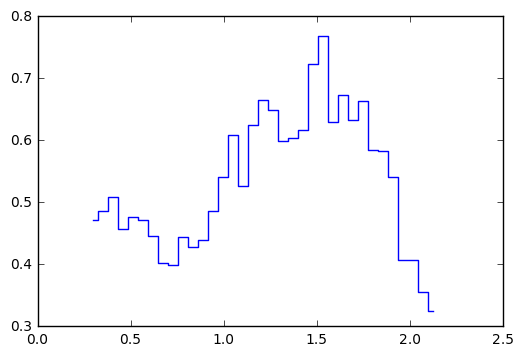

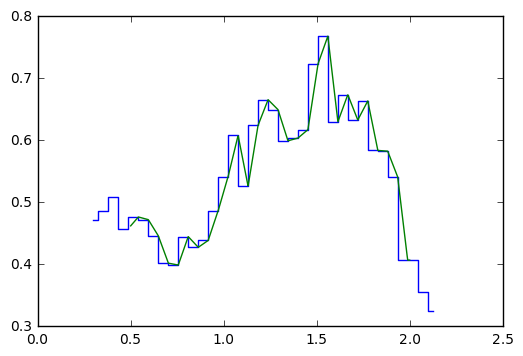

In [76]:
#Import the SpIES+SHELA data
'''
data = '/Users/johntimlin/Clustering/Combine_SpIES_Shela/Data_sets/Match_SpSh_Cand_Spec_wz.fits'
obs = pf.open(data)[1].data
gdx = ((obs.ZSPEC >= 2.9)&(obs.ZSPEC <= 5))
#Compute the redshift percentiles for the Friedmann-Diaconis rule for bin width
q75, q25 = np.percentile(obs.ZSPEC[gdx], [75 ,25])
iqr = q75 - q25
FD = 2*iqr /(len(obs.ZSPEC[gdx]))**(1/3.0)
#Set up the bin range from using the Friedmann Diaconis bin width
bins = np.arange(min(obs.ZSPEC[gdx]),max(obs.ZSPEC[gdx]),FD)
print FD
#Histogram the specz's. It must be normalized such that the integral underneath is 1. This eliminates the 
#integral of dN/dz in the denominator of Limber's equation (not shown above because =1)
num,bins = np.histogram(obs.ZSPEC[gdx],bins,normed=True)
'''

#Import the Nic's data as a lowz test

data = '/Users/johntimlin/Clustering/Ross_2009_Data/DR5QSO_uni_data.fits'
obs = pf.open(data)[1].data
gdx = ((obs.Z >= 0.3)&(obs.Z <= 2.2))
#Compute the redshift percentiles for the Friedmann-Diaconis rule for bin width
q75, q25 = np.percentile(obs.Z[gdx], [75 ,25])
iqr = q75 - q25
FD = 2*iqr /(len(obs.Z[gdx]))**(1/3.0)
#Set up the bin range from using the Friedmann Diaconis bin width
bins = np.arange(min(obs.Z[gdx]),max(obs.Z[gdx]),FD)
print FD
#Histogram the specz's. It must be normalized such that the integral underneath is 1. This eliminates the 
#integral of dN/dz in the denominator of Limber's equation (not shown above because =1)
num,bins = np.histogram(obs.Z[gdx],bins,normed=True)


#Average redshift in the bin
bavg = 0.5*(bins[:-1]+bins[1:])


#Need to interpolate to get the value of the histogram at any redshift...
intp = interpolate.interp1d(bavg,np.asarray(num))

plt.figure()
plt.plot(bins[:-1],num,linestyle = 'steps-mid')
plt.plot(np.linspace(0.5,2,1000),intp(np.linspace(0.5,2,1000)))
plt.show()

### Use CAMB to generate the DM power spectrum

<IPython.core.display.Javascript object>


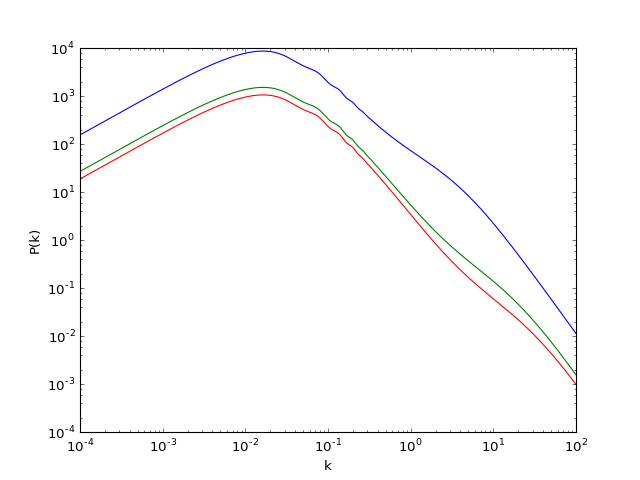

In [224]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 67.31 #H0
oc = 0.1188 #physical density of CDM 
ob = 0.02230 #physical density of baryons
#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 
pars.set_dark_energy()


#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
pars.InitPower.set_params()#ns=0.965)

z=np.linspace(0,5,100)
#z=np.linspace(0,5,100)
#k=np.exp(np.log(10)*np.linspace(-4,2,100))
k=np.logspace(-3,2,len(z))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units: output as Mpc^-3 
#instead of Mpc/h^-3 
PK = camb.get_matter_power_interpolator(pars,zs = z,zmax = z[-1], nonlinear=True, hubble_units=True, kmax = k[-1])
Z,K = np.meshgrid(z,k)
Power = PK.P(z,k)

l = np.exp(np.log(10)*np.linspace(-4,2,1000))

fig1 = plt.figure(1)
plt.loglog(l,PK.P(1,l))
plt.loglog(l,PK.P(4,l))
plt.loglog(l,PK.P(max(z),l))
plt.xlabel('k')
plt.ylabel('P(k)')

plt.show()


<IPython.core.display.Javascript object>


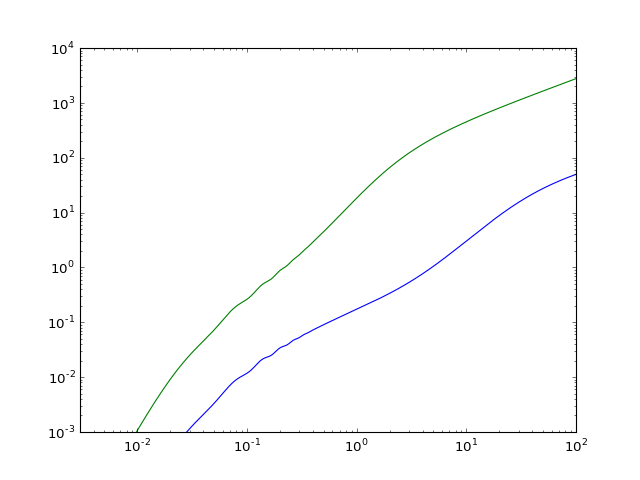

5327.74756959
13.8360491692


In [222]:
#Compute the dimensionless power spectrum delta(z,k)**2
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta

kay = np.logspace(-3,2,1000)
dimless1 = dimpower(PK,6,kay)
dimless2 = dimpower(PK,0,kay)
plt.figure(4)
plt.plot(kay,dimless)
plt.plot(kay,dimless2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(3e-3,1e2)
plt.ylim(1e-3,1e4)
plt.show()

bkg = camb.get_background(pars)
print bkg.comoving_radial_distance(2)
print camb.get_age(pars)

<IPython.core.display.Javascript object>


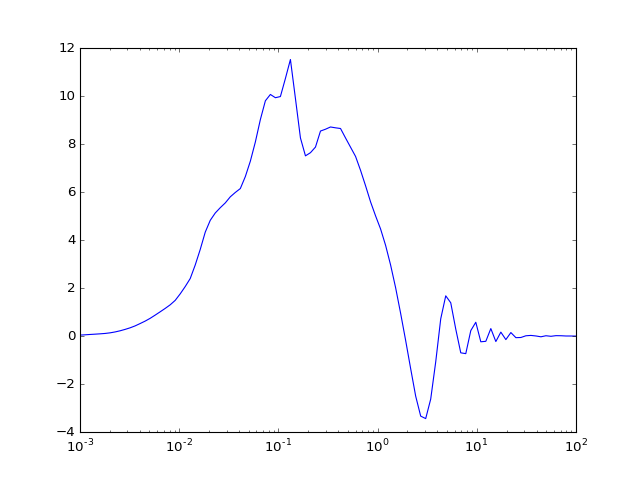

<IPython.core.display.Javascript object>


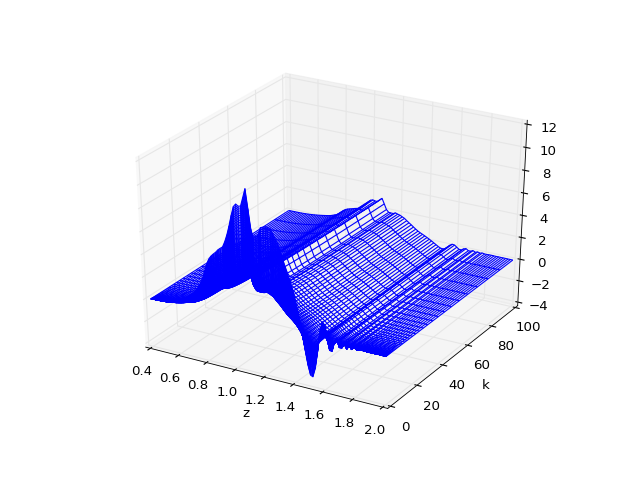

In [218]:
#define the surface to MC integrate under

def domega(theta,z,k,cambpars,dndz,Power,OmegaM,OmegaL):
    bkg = camb.get_background(cambpars)
    x = k * theta * bkg.comoving_radial_distance(z)
    om = k**-2 * dimpower(Power,z,k) * dndz(z)**2 * j0(x) * (OmegaM*(1+z)**3+OmegaL)**0.5
    return om

theta = 1./60./180.*np.pi # radians = arcmin/60/180*pi
z = np.linspace(0.4,2,100)
k = np.logspace(-3,2,100)
omegaM = (oc+ob)/(H/100.)**2
omegaL= 1.0-omegaM

test = domega(theta,z,k,pars,intp,PK,omegaM,omegaL)
Z,K = np.meshgrid(z,k)

#plt.figure(1)
plt.plot(k,test[0])
plt.xscale('log')

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Z,K,test)
ax.set_xlabel('z')
ax.set_ylabel('k')

plt.show()

In [146]:
# Bessel Function definition

x = k * theta * bkg.comoving_radial_distance(z)

plt.plot(x,j0(x))
plt.xlim(0,5)

plt.show()


ValueError: operands could not be broadcast together with shapes (100,) (50,) 

<IPython.core.display.Javascript object>


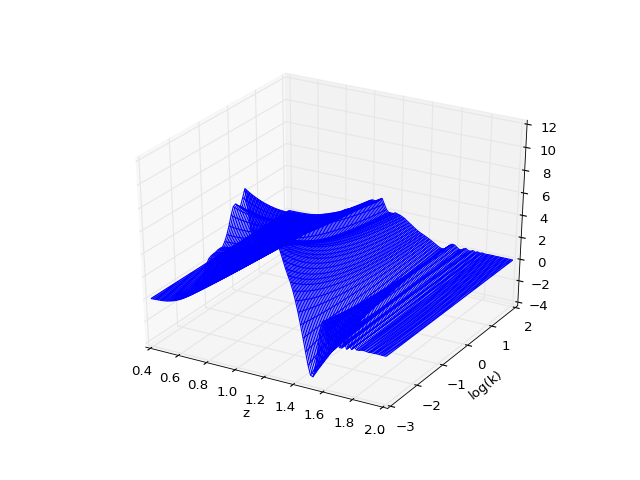

In [145]:
import palettable
import matplotlib as mpl


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

plt.figure(6)
plt.scatter(x, y, c=z, cmap=mpl.colors.ListedColormap(palettable.colorbrewer.diverging.RdYlBu_3.mpl_colors))

plt.show()


# Plotting Code Below

In [2]:
####################################
#CALCULATE Poisson and Field to Field ERROR BARS
####################################
# Get the size of the w(theta) array
size = float(len(th))
#Sum the RR's to find the total pair counts for Field to Field error calcualtion
totRR=np.sum(RR)
#Sum the DD's to find the total pair counts for Poisson error calcualtion
totQQ = np.sum(DD)
#Generate an array of the w(theta) values
om = np.asarray(w)
#Calculate the Field to Field error
#Errors = (1 + om)/np.sqrt(totRR/size)
#f2f = np.asarray(Errors)

#Calculate the Poisson errors
Errors = (1 + om)/np.sqrt(totQQ/size)
poisson = np.asarray(Errors)


NameError: name 'np' is not defined

In [5]:
####################################
#COMPUTE ERROR BARS FROM JACKKNIFE
###################################

jkfile = '/Users/johntimlin/Clustering/Combine_SpIES_Shela/Angular_Projected/SpSh_angular_Clustering_Jackknifedat_v2.txt'

jkdat = open(jkfile,'rw')


#Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
jkhead = jkdat.readline()
jknum= np.float(jkhead.split()[7])

#Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
RRjk = np.zeros([jknum,int(size)])
Xijk = np.zeros([jknum,int(size)])
Thjk = np.zeros([jknum,int(size)])

#
num=jkdat.readlines()
row = 0
k=0

for j in range(len(num)):
	#At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
	if num[j].split()[0] == 'STEP_DONE':
		row +=1
		k=0
	#For each of the JK runs, append the info into arrays
	else:
		Thjk[row,k] = float(num[j].split()[0])
		RRjk[row,k] = float(num[j].split()[3])
		Xijk[row,k] = float(num[j].split()[4])
		k+=1


#Compute the main diagonal of the covariance matrix (Update to include full matrix)
c=0
C=[]
for i in range(len(Thjk)):

	sig = (np.sqrt(np.sum(RRjk[i])/totRR)*(Xijk[i]-om))**2
	c+=sig
	if i+1 == len(Xijk):
		C.append(c)
print C



NameError: name 'np' is not defined

In [4]:
#Parameters from Myers2006 Power law fit
t = np.linspace(-1.40,2.4,15)
thet=10**t
omegaall = (0.056) * thet**(-0.91)
omegasmall=(0.11) * (10**np.linspace(-1.4,0,10))**(-0.4)
omegamid = (0.035) * (10**np.linspace(0,1.69,10))**(-0.55)
omegalarge=(0.066) * (10**np.linspace(0,2.3,10))**(-0.98)
M2007 = (0.0493) * thet**(-0.928)

NameError: name 'np' is not defined

In [19]:
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

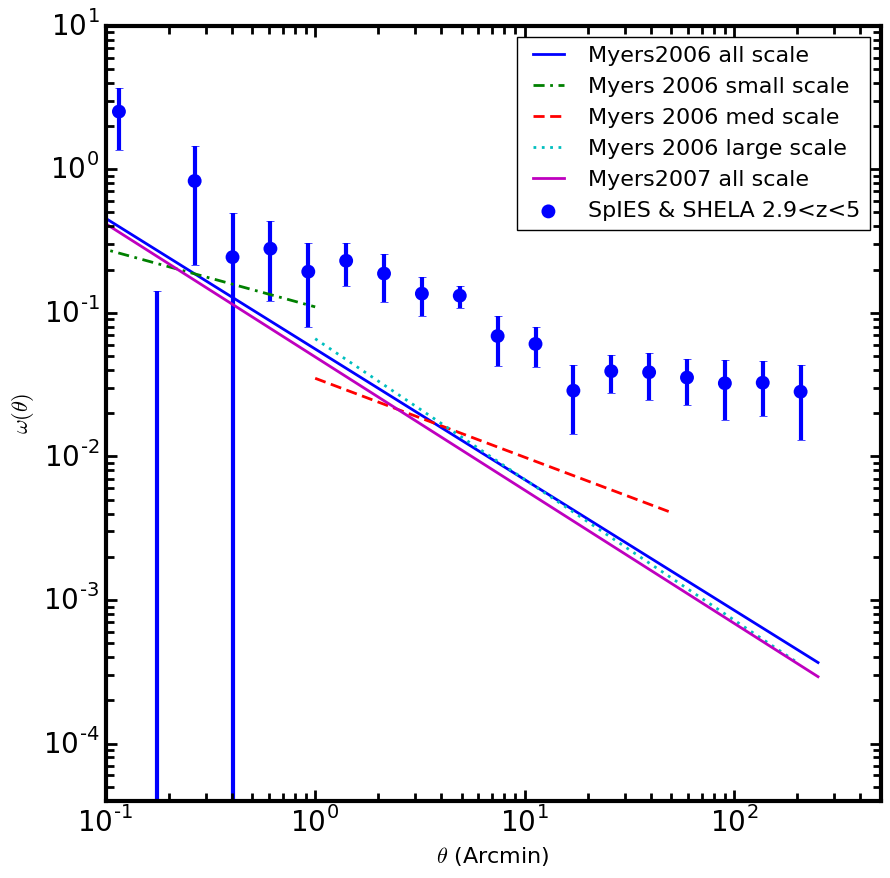

In [24]:
plt.figure(1,figsize=[10,10])
plt.scatter(th,xi,s = 100, edgecolor='None',label=('SpIES & SHELA 2.9<z<5'))
plt.errorbar(th,xi,yerr=C[0]**0.5,elinewidth=3,fmt=',',color='b')
plt.plot(thet,omegaall,linewidth=2,label = 'Myers2006 all scale')
plt.plot(10**np.linspace(-1.4,0,10),omegasmall,linewidth=2,linestyle='-.',dashes = [8,4,2,4],label = 'Myers 2006 small scale')
plt.plot(10**np.linspace(0,1.69,10),omegamid,linewidth=2,linestyle='--',dashes = [8,4,8,4],label = 'Myers 2006 med scale')
plt.plot(10**np.linspace(0,2.3,10),omegalarge,linewidth=2,linestyle=':',dashes = [2,4,2,4],label = 'Myers 2006 large scale')
plt.plot(thet,M2007,linewidth=2, color = 'm',label = 'Myers2007 all scale')

'''
x1 = np.linspace(4,25,100)
x = np.linspace(4,150,100)
Efit = ((np.sqrt(np.pi)*gamma(1/2.0)/gamma(1.0)))*(x1/8.12)**-2
Sfit = ((gamma(0.5)*gamma(1.33/2.0))/gamma(2.33/2.0)) *(x/16.1)**-2.33

plt.scatter(Er,EwEr,c='r',marker='o',label=('Eftekharzadeh 2015'))
plt.errorbar(Er,EwEr,yerr=np.asarray(eerr)/np.asarray(Er),c='r',fmt='o')
plt.plot(x1,Efit,c='r',linestyle='--',label=('Eftekharzadeh 2015 fit'))
plt.plot(x,Sfit,c='g',linestyle='--',label=('Shen 2007 fit'))
plt.scatter(sr,swsr,c='g',marker='o',label=('Shen 2007'))
plt.errorbar(sr,swsr,yerr=serr,c='g',fmt='o')
#plot the fit to SpIES data
#plt.plot(RP[(RP>3.5) & (RP<30)],Power(RP[(RP>3.5) & (RP<30)],popt[0],popt[1]))
plt.plot(RP[(RP>3.5) & (RP<30)],Powerfixed(RP[(RP>3.5) & (RP<30)],popt[0]))
'''
#plt.axvline(4)
#plt.axvline(25)
plt.xlim(10**-1,500)
plt.ylim(4*10**-5,10)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 16)
plt.ylabel(r'$\omega (\theta)$',fontsize = 16)
plt.legend(scatterpoints=1)
#plt.savefig('SpSh_angular_corr_JKerr_v2.png')
plt.show()